### MNIST dataset
Collection of 60,000 training examples and 10,000 testing examples of handwritten digits 0-9

In [3]:
import numpy as np 
import matplotlib.pyplot as plt
import math
import time
import torch
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import sys
import os

# Add scripts folder path so I can get load_mnist
repo_root = os.path.abspath("..")  # one level up from notebooks/
sys.path.append(repo_root)
print(sys.path)
from scripts.MNIST.load_mnist import load_mnist
from scripts.MNIST.train_mnist import MNIST_CNN

['c:\\Users\\caleb\\OneDrive - Uppsala universitet\\Fall 2025\\Projects Course\\mixture-of-experts-organization\\mixture-of-experts-project\\notebooks', 'c:\\Users\\caleb\\anaconda3\\python312.zip', 'c:\\Users\\caleb\\anaconda3\\DLLs', 'c:\\Users\\caleb\\anaconda3\\Lib', 'c:\\Users\\caleb\\anaconda3', '', 'c:\\Users\\caleb\\anaconda3\\Lib\\site-packages', 'c:\\Users\\caleb\\anaconda3\\Lib\\site-packages\\win32', 'c:\\Users\\caleb\\anaconda3\\Lib\\site-packages\\win32\\lib', 'c:\\Users\\caleb\\anaconda3\\Lib\\site-packages\\Pythonwin', 'c:\\Users\\caleb\\OneDrive - Uppsala universitet\\Fall 2025\\Projects Course\\mixture-of-experts-organization\\mixture-of-experts-project\\scripts\\MNIST', 'c:\\Users\\caleb\\OneDrive - Uppsala universitet\\Fall 2025\\Projects Course\\mixture-of-experts-organization\\mixture-of-experts-project\\scripts\\MNIST', 'c:\\Users\\caleb\\OneDrive - Uppsala universitet\\Fall 2025\\Projects Course\\mixture-of-experts-organization\\mixture-of-experts-project']


RuntimeError: shape '[60000, 1, 28, 28]' is invalid for input of size 0

In [ ]:
model = MNIST_CNN()

NameError: name 'train_mnist' is not defined

In [31]:
#just copied these over from train_mnist.py
BATCH_SIZE = 128
EPOCHS = 50
LEARNING_RATE = 0.001
# Load the model checkpoint
metrics = torch.load("../scripts/MNIST/checkpoints/MNIST.pt", map_location="cpu")
model = metrics["model"]
test_accuracy = metrics["test_accuracy"]
test_loss = metrics["test_loss"]
training_accuracy = metrics["training_accuracy"]
training_loss = metrics["training_loss"]
total_time = metrics["total_time"]

C:\Users\caleb\AppData\Local\Temp\ipykernel_28828\2968650220.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  metrics = torch.load("../scripts/MNIST/checkpoints/MNIST.pt"

In [32]:
print(metrics["model"])

OrderedDict({'conv1.weight': tensor([[[[ 0.5487,  0.4777, -0.5094],
          [ 0.3757,  0.4088,  0.1961],
          [-0.4942,  0.2801,  0.2701]]],


        [[[-0.5276,  0.3117,  0.3526],
          [ 0.3229,  0.3035,  0.5473],
          [ 0.1294,  0.3780,  0.2286]]],


        [[[-0.1556,  0.0850, -0.1536],
          [-0.0391, -0.1354,  0.2211],
          [-0.2631, -0.1537, -0.0941]]],


        [[[-0.1137, -0.3686, -0.6754],
          [ 0.6872,  0.1115,  0.5056],
          [ 0.2910,  0.1120,  0.4471]]],


        [[[ 0.1460,  0.4970,  0.2078],
          [-0.0394,  0.3114, -0.0096],
          [ 0.4028,  0.5398,  0.1066]]],


        [[[ 0.4549,  0.7205,  0.5898],
          [ 0.0899, -0.1339, -0.4767],
          [-0.6465, -0.8094,  0.0203]]],


        [[[ 0.4410,  0.5098,  0.2312],
          [ 0.2912,  0.5915, -0.0933],
          [ 0.1064, -0.1542, -0.1726]]],


        [[[-0.1906, -0.7782, -0.7744],
          [ 0.6253, -0.1119, -0.1534],
          [ 0.1432,  0.6672,  0.4821]]]]), 'co

In [33]:
# pytorch_total_params = sum(p.numel() for p in model.parameters())
# print(f"Total parameters in model: {pytorch_total_params}")

In [17]:
#Training test plot curve code that was provided in assignment 1 to get the plots
#modified it to contain the time and number of epochs
def training_curve_plot(title, train_costs, test_costs, train_accuracy, test_accuracy, batch_size, learning_rate, time, epochs):
    lg=18
    md=13
    sm=9
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(title, y=1.15, fontsize=lg)
    sub = f'| Batch size:{batch_size} | Learning rate:{learning_rate} | Number of Epochs:{epochs} | Training Time:{round(time)}sec |'
    fig.text(0.5, 0.99, sub, ha='center', fontsize=md)
    x = range(1, len(train_costs)+1)
    axs[0].plot(x, train_costs, label=f'Final train cost: {train_costs[-1]:.4f}')
    axs[0].plot(x, test_costs, label=f'Final test cost: {test_costs[-1]:.4f}')
    axs[0].set_title('Costs', fontsize=md)
    axs[0].set_xlabel('Epochs', fontsize=md)
    axs[0].set_ylabel('Cost', fontsize=md)
    axs[0].legend(fontsize=sm)
    axs[0].tick_params(axis='both', labelsize=sm)
    # Optionally use a logarithmic y-scale
    #axs[0].set_yscale('log')
    axs[1].plot(x, train_accuracy, label=f'Final train accuracy: {100*train_accuracy[-1]:.2f}%')
    axs[1].plot(x, test_accuracy, label=f'Final test accuracy: {100*test_accuracy[-1]:.2f}%')
    axs[1].set_title('Accuracy', fontsize=md)
    axs[1].set_xlabel('Epochs', fontsize=md)
    axs[1].set_ylabel('Accuracy (%)', fontsize=sm)
    axs[1].legend(fontsize=sm)
    axs[1].tick_params(axis='both', labelsize=sm)


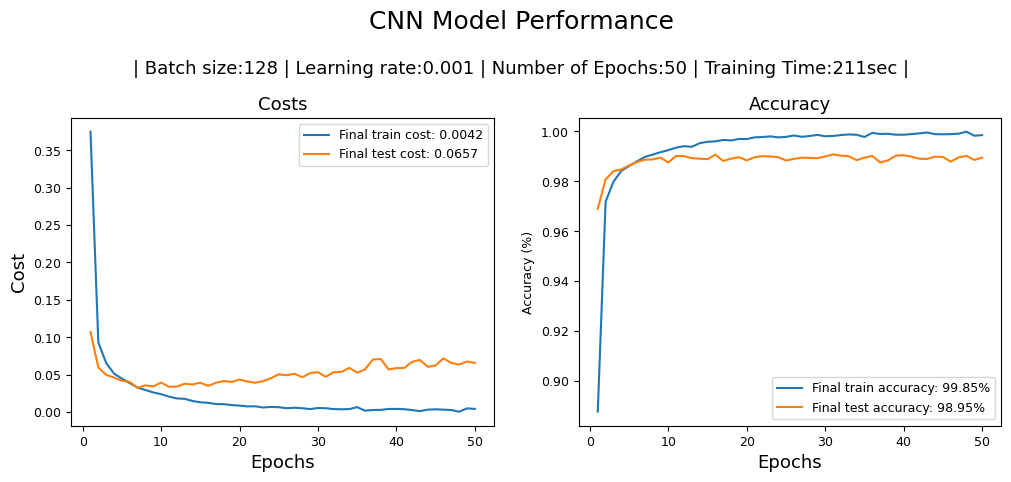

In [20]:
training_curve_plot("CNN Model Performance", training_loss, test_loss, training_accuracy, test_accuracy, 
BATCH_SIZE, LEARNING_RATE, total_time, EPOCHS)

We see some clear overfitting and probably the best model is around epoch 10, but even so our model is nearly 99% accuracy on the test dataset which is good